In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Capstone/Flickr8k")

In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

In [0]:
# Method that loads a document into memory
def load_doc(filename):
    file = open(filename,'r')
    doc = file.read()
    file.close()
    return doc

In [0]:
# Below is the path for the file "Flickr8k.token.txt" on your disk
filename = "Flickr8k_text/Flickr8k.token.txt"
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [0]:
# Adds the Image name and Image description to a dictionary and returns the mapping dictionary
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

In [0]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [0]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [0]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [0]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions,filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below path contains all the images
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []
for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 3372.0597891807556


In [0]:
import pickle

In [0]:
import pickle
# Save the bottleneck train features to disk
with open("Flickr8k_Dataset/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 574.5473577976227


In [0]:
# Save the bottleneck test features to disk
with open("Flickr8k_Dataset/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
print('Photos: test=%d' % len(encoding_test))

Photos: test=1000


In [0]:
train_features = load(open("Flickr8k_Dataset/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [0]:
encoding_test = load(open("Flickr8k_Dataset/encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_test))

Photos: train=1000


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
# Load Glove vectors
glove_dir = r'glove.6B.200d'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1652, 200)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se4 = LSTM(256)(se3)
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 34, 200)      0           embedding_1[0][0]                
____________________________________________________________________________________________

In [0]:
model.layers[1]

In [0]:
model.layers

In [0]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 2017s 1s/step - loss: 4.2009
Epoch 1/1
2000/2000 [==============================] - 2015s 1s/step - loss: 3.4564
Epoch 1/1
2000/2000 [==============================] - 2023s 1s/step - loss: 3.2009
Epoch 1/1
2000/2000 [==============================] - 2024s 1s/step - loss: 3.0492
Epoch 1/1
2000/2000 [==============================] - 2020s 1s/step - loss: 2.9417
Epoch 1/1
2000/2000 [==============================] - 2014s 1s/step - loss: 2.8536
Epoch 1/1
2000/2000 [==============================] - 2012s 1s/step - loss: 2.7839
Epoch 1/1
2000/2000 [==============================] - 2012s 1s/step - loss: 2.7254
Epoch 1/1
2000/2000 [==============================] - 2011s 1s/step - loss: 2.6770
Epoch 1/1
2000/2000 [==============================] - 2009s 1s/step - loss: 2.6310


In [0]:
model.load_weights('model_weights/model_9.h5')

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 2022s 1s/step - loss: 2.6796
Epoch 1/1
2000/2000 [==============================] - 2016s 1s/step - loss: 2.5906
Epoch 1/1
2000/2000 [==============================] - 2028s 1s/step - loss: 2.5448
Epoch 1/1
2000/2000 [==============================] - 2002s 1s/step - loss: 2.5124
Epoch 1/1
2000/2000 [==============================] - 2001s 1s/step - loss: 2.4826
Epoch 1/1
2000/2000 [==============================] - 2023s 1s/step - loss: 2.4552
Epoch 1/1
2000/2000 [==============================] - 2036s 1s/step - loss: 2.4283
Epoch 1/1
2000/2000 [==============================] - 2038s 1s/step - loss: 2.4069
Epoch 1/1
2000/2000 [==============================] - 2038s 1s/step - loss: 2.3828
Epoch 1/1
2000/2000 [==============================] - 2037s 1s/step - loss: 2.3632


In [0]:
model.save('model_weights/model_DoubleLayerLSTM' + str(i) + '.h5')

In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

In [0]:
model.save_weights('model_weights/model_30.h5')

In [0]:
pwd

'/content/drive/My Drive/Capstone/Flickr8k'

In [0]:
#model.load_weights('model_weights_Pavan/model_30.h5')
model.load_weights('model_weights/model_DoubleLayerLSTM9.h5')

In [0]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [0]:
with open("Flickr8k_Dataset/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

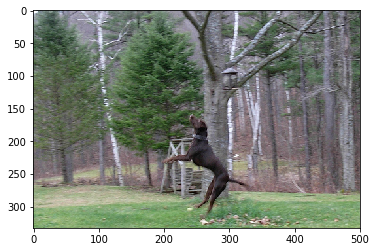

Greedy: the dog is running through the woods


In [0]:
z = 15
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [0]:
from keras.preprocessing import image

In [0]:
testPath = r"D:\Personal\TiruPhotos"
testImage = testPath + '\DSC01535.JPG'
encoding_train = {}
img = image.load_img(testImage, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
fea_vec = model_new.predict(x) # Get the encoding vector for the image
fea_vec = np.reshape(fea_vec, fea_vec.shape[1])

FileNotFoundError: ignored

In [0]:
image = fea_vec.reshape((1,2048))

In [0]:
x=plt.imread(testImage)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [0]:
import nltk

In [0]:
nltk.__version__

'3.4.5'

In [0]:
pip install --upgrade nltk

     |████████████████████████████████| 1.5MB 3.5MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449909 sha256=c6d08f39dcfc8addee54899703c6f63a7ea21f0a8a0909601f6a542389eb3411
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [0]:
from nltk.translate.meteor_score import meteor_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def get_avg_metor_scores():
  total = 0
  avg = 0
  n = len(test_img)
  for z in range(n):
    pic = list(encoding_test.keys())[z]
    references = descriptions[pic.split('.')[0]]
    image = encoding_test[pic].reshape((1,2048))
    predicted = greedySearch(image)
    cur_m_score = meteor_score(references,predicted)
    total += cur_m_score
  avg = total / n
  return avg

In [0]:
avgScore = get_avg_metor_scores()
print(avgScore)

0.2933810599260407


In [0]:
descriptions['751737218_b89839a311']

NameError: ignored

In [0]:
test_img

['Flickr8k_Dataset/Flicker8k_Dataset/751737218_b89839a311.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1472230829_803818a383.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/132489044_3be606baf7.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/541063517_35044c554a.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/533713007_bf9f3e25b4.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3348385580_10b53391f9.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3655074079_7df3812bc5.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3569406219_f37ebf7b92.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2256133102_e2c8314ecb.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2170222061_e8bce4a32d.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/270816949_ffad112278.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3592968286_b63c81bcd2.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2922222717_12195af92d.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3139160252_75109e9e05.jpg',
 'Flickr8k_Dataset/Flicker8k_D

In [0]:
encoding_test

{'751737218_b89839a311.jpg': array([0.24400663, 0.2922991 , 0.4524935 , ..., 0.60977256, 0.57402676,
        0.57239753], dtype=float32),
 '1472230829_803818a383.jpg': array([0.1043063 , 0.03211996, 0.22764866, ..., 0.44502524, 0.30378944,
        0.8912109 ], dtype=float32),
 '132489044_3be606baf7.jpg': array([0.06209818, 0.18584044, 0.56355435, ..., 0.        , 0.20012487,
        0.9870733 ], dtype=float32),
 '541063517_35044c554a.jpg': array([0.2714022 , 0.02895158, 0.28812814, ..., 0.6430414 , 0.8589425 ,
        0.45375445], dtype=float32),
 '533713007_bf9f3e25b4.jpg': array([0.7572875 , 0.29789627, 1.4512738 , ..., 0.8794079 , 1.4617872 ,
        1.1212451 ], dtype=float32),
 '3348385580_10b53391f9.jpg': array([0.05648957, 0.26828727, 0.1229101 , ..., 0.17617352, 0.12715836,
        0.5156182 ], dtype=float32),
 '3429956016_3c7e3096c2.jpg': array([0.21194702, 0.83996433, 0.15731348, ..., 0.16018957, 0.41710174,
        0.63884276], dtype=float32),
 '3655074079_7df3812bc5.jpg': a